In [1]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import threading
import time
from math import sin, cos, pi
import pandas as pd

plt.style.use("seaborn-whitegrid")

C:\Users\elibr\AppData\Local\Temp\ipykernel_9448\1898896342.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Scientific Computing - Measuring Computational Efficiency

Computational efficiency is highly important for many applications of scientific computing, particularly in regards to working with large datasets or performing large numbers of calculations.

## Goal:

Compute an approximation of a square wave via a Fourier Series expansion. Calculate the partial sum to the 1e5 frequency.
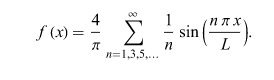

## Methodology:

A variety of different techniques were used to systematically calculate and sum the fourier frequency and components. Each technique was timed, and each time was logged into a list. The times are then compared to see which method is the most efficient.

In [2]:
vals = np.linspace(0, 4, 1001) # Input array
n = np.linspace(0, 100000,100001) # frequencies
odds = n[n%2 != 0] # filter for only odd frequencies

## Method 1: Looping

Iterate through every frequency via a conventional for loop. Calculate the frequency component and add to the partial sum in each iteration.

In [3]:
square_wave_vals = np.zeros(len(vals)) # Initial sum

@np.vectorize
def fourier_expand(n, L, x):
    f = (1/n)*sin((n*pi*x)/L) # frequency
    return f

st = time.time()

for i in odds:
    square_wave_vals += fourier_expand(i, 2, vals)

square_wave_vals *= (4/pi) # normalize
et = time.time()

time1 = et-st
print(f'Elapsed time: {time1} seconds')


Elapsed time: 83.08029460906982 seconds


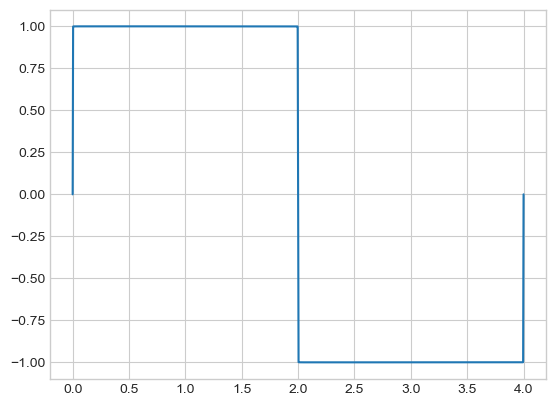

In [4]:
plt.plot(vals, square_wave_vals)

## Method 2: 2-D Vectorization and Broadcasting

Convert and transpose odds to column vector, and input values into row vector. This is part of a process called broadcasting that enables Numpy to vectorize multiple input arrays with *different* numbers of values. A 2-d array is created with each row corresponding to a frequency over the input array. The array is then summed.

In [5]:
a = np.array([odds]).T # transpose frequency array
b = np.array([vals]) # input array

st = time.time()
c = fourier_expand(a, 2, b) # creates 2d matrix - each row corresponds to frequency iterated over input values
sw = c.sum(axis=0) * (4/pi) # sums matrix by row & normalizes
et = time.time()
time2 = et - st
print(f'Elapsed time: {time2} seconds')


Elapsed time: 44.05659222602844 seconds


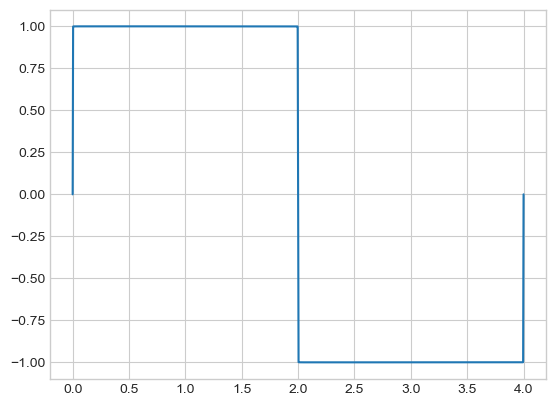

In [6]:
plt.plot(vals, sw)

## Method 3: Concurrency

Unlike conventional programming, where each line executes after the previous line is finished, concurrency involves a series of tasks where succeeding tasks are executed without necessarily waiting for the previous task to be finished.

In [7]:
square_wave_vals = np.zeros(len(vals))

@np.vectorize
def make_square_wave(i):
    global square_wave_vals
    square_wave_vals += fourier_expand(i, 2, vals)

st = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor: #each iteration will concurrently add the frequency component to the square wave array
    results = executor.map(make_square_wave, odds)

square_wave_vals *= (4/pi)

et = time.time()

time3 = et - st
print(f'Elapsed time: {time3} seconds')


Elapsed time: 232.03342390060425 seconds


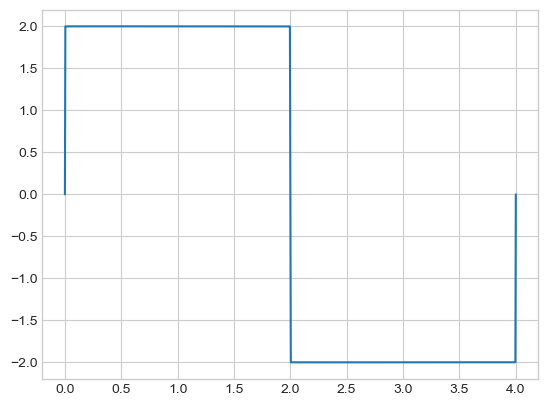

In [8]:
plt.plot(vals, square_wave_vals)

## Method 4: Faster Array Computation with Numexpr

Utilizes the Numexpr library which speeds the computation of array calculations. Modifies the second vectorized technique by using numexpr to calculate the fourier coefficients.

In [9]:
import numexpr as ne

In [10]:
def ne_fourier_expand(n, L, x):
    f = ne.evaluate('(1/n)*sin((n*pi*x)/L)') # Numexpr computation
    return f

st = time.time()
c = ne_fourier_expand(a, 2, b)
ne_sw = c.sum(axis=0) * (4/pi)
et = time.time()
time4 = et - st
print(f'Elapsed time: {time4} seconds')

Elapsed time: 0.652062177658081 seconds


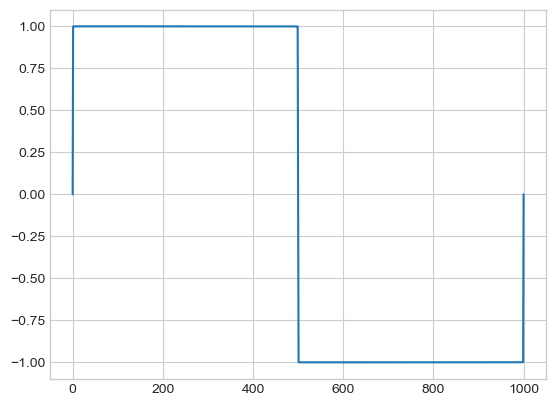

In [11]:
plt.plot(ne_sw)

In [12]:
results = {
    "Technique": ['Looping', 'Vectorization', 'Concurrency', 'Numexpr'],
    "Time(s)": [time1, time2, time3, time4]
}

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='Time(s)', ascending=True)

In [13]:
results_df

,Technique,Time(s)
3,Numexpr,0.652062
1,Vectorization,44.056592
0,Looping,83.080295
2,Concurrency,232.033424


[Text(0, 0, '0.65'),
 Text(0, 0, '44.06'),
 Text(0, 0, '83.08'),
 Text(0, 0, '232.03')]

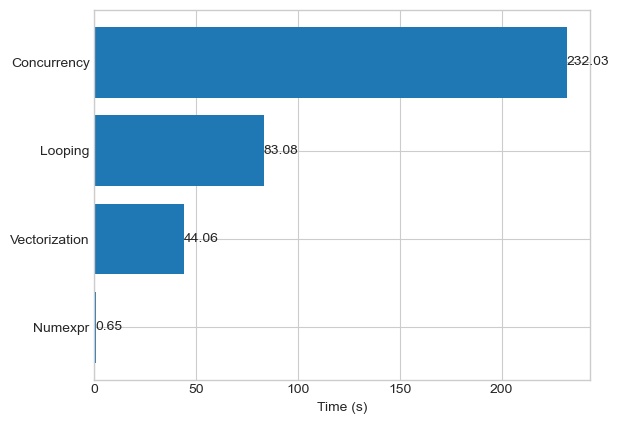

In [14]:
y = np.arange(len(results_df['Technique']))
width = 0.35

fig, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_yticks(y)
ax.set_yticklabels(results_df['Technique'])

bars=ax.barh(results_df['Technique'], round(results_df['Time(s)'], 2))

ax.bar_label(bars)


## Conclusion:

Use of vectorization proved shockingly effective with Numexpr library. By pairing vector operations with faster array evaluation, the amount of time was reduced to nearly a tenth of a second, as compared with around 20 seconds for looping. Concurrency was exceptionally slow.

## Implications

Utilizing vector wise operations on custom functions can be a very effective way to optimize programs. While traditional loops can work fine on small data sets or for tasks with lesser amounts of repetition, once tasks become more computationally expensive, vectorization can make code significantly more efficient which is valuable for scientific computing.